In [4]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate

In [5]:
FPS = 25
last_frame = 6533-1

In [6]:
seq_data = []

for i in range(2):
    seq_data.append(pd.read_csv('Emotion/OneManBand-Seq'+str(i+1)+'.csv', 
                            sep=";", 
                            names=["time","valence","arousal","expression"]))

    seq_data[i] = seq_data[i][seq_data[i].time >=0]

event_file = open('Event/one_man_band_events_filtered.json', 'r')
event_data = json.load(event_file)
event_file.close()

In [7]:
data = {}

data["frame"] = np.ndarray(0)

for i in range(2):
    data["frame"] = np.append(data["frame"], seq_data[i].time.to_numpy()*(FPS))

data["frame"] = np.append(data["frame"], np.arange(0,6533+1,1))
data["frame"].sort()

data["frame"] = np.unique(data["frame"])

n_frame = len(data["frame"])

data["valence"] = []
data["arousal"] = []
data["expression"] = []


for i in range(2):
    df = seq_data[i]

    data["valence"].append(np.ndarray(n_frame))
    data["arousal"].append(np.ndarray(n_frame))
    data["expression"].append(np.ndarray(n_frame, dtype=str))

    line_index = 0

    for j in range(n_frame):
        
        next_line_index = line_index + 1

        if next_line_index == df.shape[0]:
            next_line_index -= 1

        line_row = df.iloc[line_index]
        next_row = df.iloc[next_line_index]

        line_frame = line_row["time"]*FPS
        next_frame = next_row["time"]*FPS

        line_distance = abs(data["frame"][j]-line_frame)
        next_distance = abs(data["frame"][j]-next_frame)

        if line_distance > next_distance:
            line_index += 1

            valence = next_row["valence"]
            arousal = next_row["arousal"]
            expression = next_row["expression"]
        else:
            valence = line_row["valence"]
            arousal = line_row["arousal"]
            expression = line_row["expression"]
        
        
        data["valence"][i][j] = valence
        data["arousal"][i][j] = arousal
        data["expression"][i][j] = expression


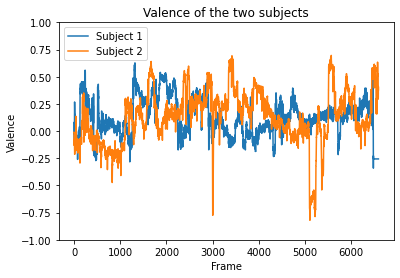

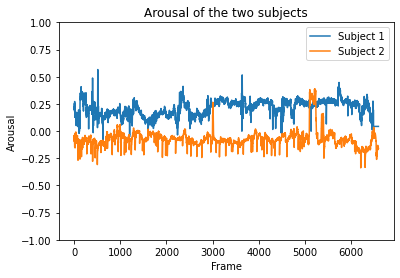

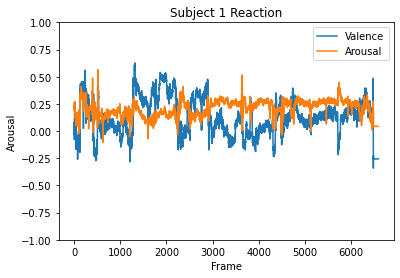

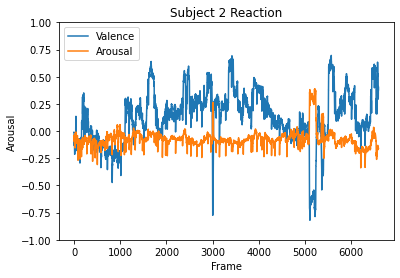

In [7]:
#Valence
fig = plt.figure()
plt.plot(data["frame"], data["valence"][0])
plt.plot(data["frame"], data["valence"][1])
plt.ylim(-1, 1)

plt.legend(["Subject 1", "Subject 2"])
plt.title("Valence of the two subjects")
plt.ylabel("Valence")
plt.xlabel("Frame")

plt.show()
fig.savefig("Results/Valence of the two subjects.png")


#Arousal
fig = plt.figure()
plt.plot(data["frame"], data["arousal"][0])
plt.plot(data["frame"], data["arousal"][1])
plt.ylim(-1, 1)

plt.legend(["Subject 1", "Subject 2"])
plt.title("Arousal of the two subjects")
plt.ylabel("Arousal")
plt.xlabel("Frame")

plt.show()
fig.savefig("Results/Arousal of the two subjects.png")

#Subjects

for i in range(2):
    fig = plt.figure()
    plt.plot(data["frame"], data["valence"][i])
    plt.plot(data["frame"], data["arousal"][i])
    plt.ylim(-1, 1)

    plt.legend(["Valence", "Arousal"])
    plt.title("Subject "+str(i+1)+" Reaction")
    plt.ylabel("Arousal")
    plt.xlabel("Frame")

    plt.show()
    fig.savefig("Results/Subject "+str(i+1)+" Reaction"+".png")


In [8]:
#Correlation

correlation = {}
correlation["Valence between subjects"] = np.corrcoef(data["valence"][0], data["valence"][1])[0][1]
correlation["Arousal between subjects"] = np.corrcoef(data["arousal"][0], data["arousal"][1])[0][1]
correlation["Valence and Arousal of subject 1"] = np.corrcoef(data["arousal"][0], data["valence"][0])[0][1]
correlation["Valence and Arousal of subject 2"] = np.corrcoef(data["arousal"][1], data["valence"][1])[0][1]

print("Correlation")

for key in correlation:
    print(key+":", "{0:.2f}".format(correlation[key]))

correlation_file = open("Results/Correlation.json", "w")
json.dump(correlation, correlation_file)
correlation_file.close()

Correlation
Valence between subjects: 0.00
Arousal between subjects: 0.03
Valence and Arousal of subject 1: -0.06
Valence and Arousal of subject 2: -0.35


In [9]:
data["actor_presence"] = np.zeros((3, n_frame), bool)
data["actor_action"] = np.ndarray((3, n_frame), dtype='<U39')

for i in range(3):
    for j in range(n_frame):
        frame = data["frame"][j]
        if str(int(frame)) in event_data[str(i)] or (str(np.floor(frame)) in event_data[str(i)] and str(np.ceil(frame)) in event_data[str(i)]):
            data["actor_presence"][i][j] = True
            data["actor_action"][i][j] = event_data[str(i)][str(int(frame))]["action"]

In [10]:
data["event"] = {}

actual_event_id = 0

durations = []

for i in range(3):
    start = -1
    end = -1

    for j in range(n_frame):
        if data["actor_presence"][i][j]:
            if start == -1:
                start = j
        else:
            if start != -1:
                end = j

                durations.append(data["frame"][end] - data["frame"][start])

                event = {}
                event["id"] = actual_event_id
                event["start"] = data["frame"][start]
                event["end"] = data["frame"][end]
                event["actor_id"] = i
                event["action"] = data["actor_action"][i][start]
                
                data["event"][actual_event_id] = event

                actual_event_id += 1

                start = -1
    


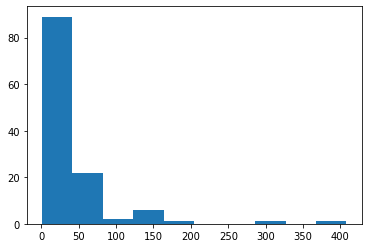

1.00 - 41.70 : 89.0
41.70 - 82.40 : 22.0
82.40 - 123.10 : 2.0
123.10 - 163.80 : 6.0
163.80 - 204.50 : 1.0
204.50 - 245.20 : 0.0
245.20 - 285.90 : 0.0
285.90 - 326.60 : 1.0
326.60 - 367.30 : 0.0
367.30 - 408.00 : 1.0


In [11]:
counts, edges, _ = plt.hist(durations)
plt.show()

for i in range(counts.shape[0]):
    print("{0:.2f}".format(edges[i]), "-", "{0:.2f}".format(edges[i+1]), ":", counts[i])

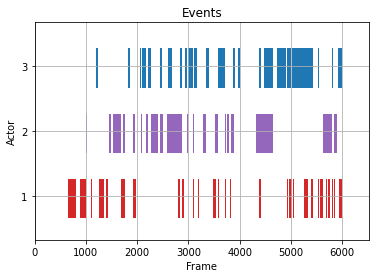

In [12]:
#Plot reference: https://www.geeksforgeeks.org/python-basic-gantt-chart-using-matplotlib/

fig, ax = plt.subplots()

plt.title("Events")

ax.set_xlabel('Frame')
ax.set_ylabel('Actor')

ax.set_ylim(0, 50)
ax.set_xlim(0, last_frame)

ax.set_yticks([10, 25, 40])
ax.set_yticklabels(['1', '2', '3'])
  

ax.grid(True)

for event_id in data["event"]:
    event = data["event"][event_id]
    
    

    if event["actor_id"] == 0:
        line_range = (5,9)
        color = "red"
    elif event["actor_id"] == 1:
        line_range = (20,9)
        color = "purple"
    else:
        line_range = (35,9)
        color = "blue"
    
    start = event["start"]
    duration = event["end"]-start

   
    ax.broken_barh([(start, duration)], line_range, facecolors=('tab:'+color))

plt.show()
fig.savefig("Results/Events.png")


In [13]:
# Filter events
for event_id in list(data["event"].keys()):
    event = data["event"][event_id]
    

    
    start = event["start"]
    duration = event["end"]-start

    if duration < 40:
      del data["event"][event_id]
        

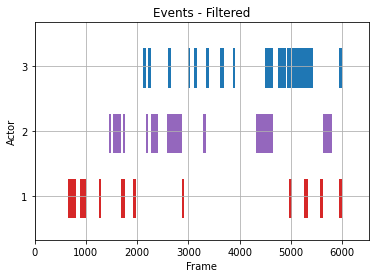

In [14]:
fig, ax = plt.subplots()

plt.title("Events - Filtered")

ax.set_xlabel('Frame')
ax.set_ylabel('Actor')

ax.set_ylim(0, 50)
ax.set_xlim(0, last_frame)


ax.set_yticks([10, 25, 40])
ax.set_yticklabels(['1', '2', '3'])
  

ax.grid(True)

text_up = [False, False, False]

for event_id in data["event"]:
    event = data["event"][event_id]
    
    

    if event["actor_id"] == 0:
        line_range = (5,9)
        color = "red"
    elif event["actor_id"] == 1:
        line_range = (20,9)
        color = "purple"
    else:
        line_range = (35,9)
        color = "blue"
    
    start = event["start"]
    duration = event["end"]-start

    ax.broken_barh([(start, duration)], line_range, facecolors=('tab:'+color))

    text_position = line_range[0]-2.5

    if text_up[event["actor_id"]]:
        text_position += 10

    #plt.text(start+(duration/2), text_position, event["action"][0], rotation=0, size=10)
    
    text_up[event["actor_id"]] = not text_up[event["actor_id"]]


plt.show()
fig.savefig("Results/Events - Filtered.png")

In [127]:
data["valence_smoothed"] = []
data["arousal_smoothed"] = []

for i in range(2):
    for dimension in ["valence", "arousal"]:

        smoothed = np.zeros_like(data[dimension][i])
        sigma = 10

        for j in range(data["frame"].shape[0]):
            frame = data["frame"][j]

            kernel = np.exp(-np.power((data['frame']-frame), 2)/(2*np.power(sigma, 2)))
            kernel = kernel / sum(kernel)

            smoothed[j] = np.sum(data[dimension][i] * kernel)

        data[dimension+"_smoothed"].append(smoothed)

        print("Subject "+str(i) + " " + dimension + " smoothed")

Subject 0 valence smoothed
Subject 0 arousal smoothed
Subject 1 valence smoothed
Subject 1 arousal smoothed


In [343]:
def event_tonic_reaction(event_id, subject):
    start = data["event"][event_id]["start"]
    end = data["event"][event_id]["end"]

    mask = np.logical_and(data["frame"]>=start, data["frame"]<=end)
    
    frames = data["frame"][mask]
    valence = data["valence_smoothed"][subject][mask]
    arousal = data["arousal_smoothed"][subject][mask]

    around_mask = np.logical_and(data["frame"]>=start-5, data["frame"]<=end+5)
    valence_around = data["valence_smoothed"][subject][around_mask]
    arousal_around = data["arousal_smoothed"][subject][around_mask]


    valence_mean = np.mean(valence_around)
    arousal_mean = np.mean(arousal_around)
    valence_std = np.std(valence_around)
    arousal_std = np.std(arousal_around)
    valence_phi = valence_mean + (valence_std)
    arousal_phi = arousal_mean + (arousal_std)

    valence[np.logical_and(valence<valence_phi, valence>-valence_phi)] = 0
    arousal[np.logical_and(arousal<arousal_phi, arousal>-arousal_phi)] = 0

    valence_reaction = integrate.simps(valence, frames)/(end-start)
    arousal_reaction = integrate.simps(arousal, frames)/(end-start)

    return valence_reaction, arousal_reaction

def event_phasic_reaction(event_id, subject):
    start = data["event"][event_id]["start"]
    end = data["event"][event_id]["end"]

    mask = np.logical_and(data["frame"]>=start, data["frame"]<=end)

    frames = data["frame"][mask]
    valence = data["valence_smoothed"][subject][mask]
    arousal = data["arousal_smoothed"][subject][mask]

    valence_mean = np.mean(valence)
    arousal_mean = np.mean(arousal)

    valence_std = np.std(valence)
    arousal_std = np.std(arousal)

    valence_phi = valence_mean + (2*valence_std)
    arousal_phi = arousal_mean + (2*arousal_std)

    valence_derivative = np.diff(valence)/np.diff(frames)
    valence_derivative = np.insert(valence_derivative, 0, 0.1)
    
    arousal_derivative = np.diff(arousal)/np.diff(frames)
    arousal_derivative = np.insert(arousal_derivative, 0, 0.1)

    valence_peak_mask = np.abs(valence_derivative) < 1e-2
    arousal_peak_mask = np.abs(arousal_derivative) < 1e-2

    valence_peak = valence[valence_peak_mask]
    arousal_peak = arousal[arousal_peak_mask]
    
    valence_reaction_index = np.argmax(np.abs(valence_peak))
    arousal_reaction_index = np.argmax(np.abs(arousal_peak))

    valence_reaction = valence_peak[valence_reaction_index]
    arousal_reaction = arousal_peak[arousal_reaction_index]

    return valence_reaction, arousal_reaction

for event_id in data["event"]:
    data["event"][event_id]["tonic_reaction"] = []
    data["event"][event_id]["phasic_reaction"] = []
    for subject in range(2):
        valence_reaction, arousal_reaction = event_tonic_reaction(event_id, subject)
        data["event"][event_id]["tonic_reaction"].append({"valence": valence_reaction, "arousal": arousal_reaction})

        valence_reaction, arousal_reaction = event_phasic_reaction(event_id, subject)
        data["event"][event_id]["phasic_reaction"].append({"valence": valence_reaction, "arousal": arousal_reaction})




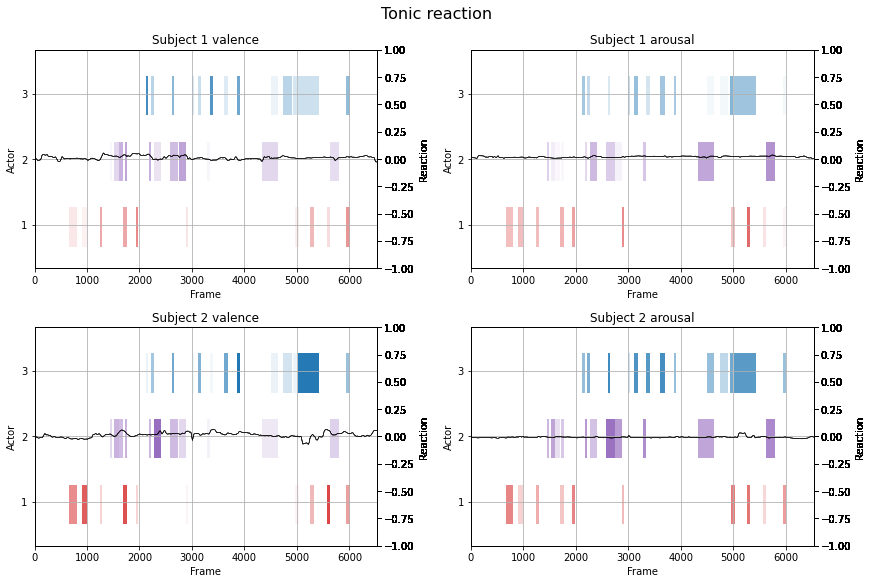

In [337]:
valence_tonic = [[],[]]
arousal_tonic = [[],[]]
for event_id in data["event"]:
    for i in range(2):
        valence_tonic[i].append(data["event"][event_id]["tonic_reaction"][i]["valence"])
        arousal_tonic[i].append(data["event"][event_id]["tonic_reaction"][i]["arousal"])
max_reaction = max(np.max(valence_tonic), np.max(arousal_tonic))

fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(12,8))
for i in range(2): #subject
    for j in range(2): #dimension

        dimension = ["valence", "arousal"][j]

        ax[i][j].set_title("Subject "+str(i+1) + " " + dimension)

        ax[i][j].set_xlabel('Frame')
        ax[i][j].set_ylabel('Actor')

        ax[i][j].set_ylim(0, 50)
        ax[i][j].set_xlim(0, last_frame)

        ax[i][j].set_yticks([10, 25, 40])
        ax[i][j].set_yticklabels(['1', '2', '3'])
        

        ax[i][j].grid(True)

        for event_id in data["event"]:
            event = data["event"][event_id]
            
            if event["actor_id"] == 0:
                line_range = (5,9)
                color = "red"
            elif event["actor_id"] == 1:
                line_range = (20,9)
                color = "purple"
            else:
                line_range = (35,9)
                color = "blue"
            
            start = event["start"]
            duration = event["end"]-start
   
            alpha = abs(event["tonic_reaction"][i][dimension])/max_reaction

            ax2 = ax[i][j].twinx()

            ax2.plot(data["frame"], data[dimension+"_smoothed"][i]/10, alpha=0.1, color="black", linewidth=0.5)
            ax2.set_ylabel("Reaction")

            ax2.set_ylim(-1,1)

            ax[i][j].broken_barh([(start, duration)], line_range, facecolors=('tab:'+color), alpha=max(alpha, 0.05))
            

fig.suptitle("Tonic reaction", fontsize=16)

plt.show()
fig.savefig("Results/Tonic reaction.png", facecolor='white', transparent=False )

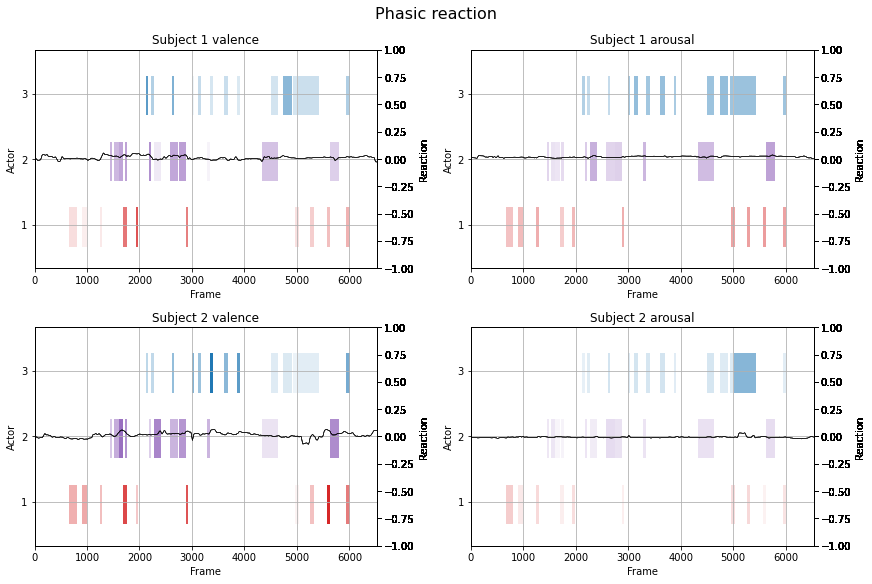

In [344]:
valence_phasic = [[],[]]
arousal_phasic = [[],[]]
for event_id in data["event"]:
    for i in range(2):
        valence_phasic[i].append(data["event"][event_id]["phasic_reaction"][i]["valence"])
        arousal_phasic[i].append(data["event"][event_id]["phasic_reaction"][i]["arousal"])
max_reaction = max(np.max(valence_phasic), np.max(arousal_phasic))

fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(12,8))
for i in range(2): #subject
    for j in range(2): #dimension

        dimension = ["valence", "arousal"][j]

        ax[i][j].set_title("Subject "+str(i+1) + " " + dimension)

        ax[i][j].set_xlabel('Frame')
        ax[i][j].set_ylabel('Actor')

        ax[i][j].set_ylim(0, 50)
        ax[i][j].set_xlim(0, last_frame)

        ax[i][j].set_yticks([10, 25, 40])
        ax[i][j].set_yticklabels(['1', '2', '3'])
        

        ax[i][j].grid(True)

        for event_id in data["event"]:
            event = data["event"][event_id]
            
            if event["actor_id"] == 0:
                line_range = (5,9)
                color = "red"
            elif event["actor_id"] == 1:
                line_range = (20,9)
                color = "purple"
            else:
                line_range = (35,9)
                color = "blue"
            
            start = event["start"]
            duration = event["end"]-start
   
            alpha = abs(event["phasic_reaction"][i][dimension])/max_reaction

            ax2 = ax[i][j].twinx()

            ax2.plot(data["frame"], data[dimension+"_smoothed"][i]/10, alpha=0.1, color="black", linewidth=0.5)
            ax2.set_ylabel("Reaction")

            ax2.set_ylim(-1,1)

            ax[i][j].broken_barh([(start, duration)], line_range, facecolors=('tab:'+color), alpha=max(alpha, 0.05))
            

fig.suptitle("Phasic reaction", fontsize=16)

plt.show()
fig.savefig("Results/Phasic reaction.png", facecolor='white', transparent=False )

In [288]:
#index = np.argmax(np.abs(valence[0]))

index = 21


{'id': 84,
 'start': 2122.0,
 'end': 2170.0,
 'actor_id': 2,
 'action': 'carry/hold (an object)',
 'tonic_reaction': [{'valence': 0.10875189567446532,
   'arousal': 0.051748975470769225},
  {'valence': 0.010912217272042205, 'arousal': -0.06156981709673564}],
 'phasic_reaction': [{'valence': 0.45641777606234657,
   'arousal': 0.21249048373689103},
  {'valence': 0.17962762598770854, 'arousal': -0.053969964622094434}]}

array([ 4, 21, 14,  3, 17, 13, 12,  5, 16, 23, 30, 10, 11, 19, 33,  9, 22,
       20,  8, 25, 27, 32,  7, 29, 31,  0,  6, 26,  1, 28, 15, 18, 24,  2],
      dtype=int64)

In [348]:


for reaction_type in ["tonic", "phasic"]:
    print("Biggest "+reaction_type+" Reaction")

    for subject in range(2):
        print()
        print("Subject", subject+1)

        for dimension in ["valence", "arousal"]:
            print("\t", dimension)

            if reaction_type == "phasic":
                if dimension == "valence":
                    index_by_reaction = np.argsort(np.abs(valence_phasic[subject]))
                else:
                    index_by_reaction = np.argsort(np.abs(arousal_phasic[subject]))
            else:
                if dimension == "valence":
                    index_by_reaction = np.argsort(valence_tonic[subject])
                else:
                    index_by_reaction = np.argsort(arousal_tonic[subject])
                    

            for i in range(2):
                index = index_by_reaction[-1-i]

                key = list(data["event"].keys())[index]

                event = data["event"][key]

                print(key, 
                "{0:.5f}".format(event["phasic_reaction"][subject][dimension]),
                event["start"],"-", event["end"],"/",
                event["start"]/FPS,"-",event["end"]/FPS, "|",
                (event["end"]-event["start"])/FPS)

    print("\n\n")

Biggest tonic Reaction

Subject 1
	 valence
84 0.45642 2122.0 - 2170.0 / 84.88 - 86.8 | 1.92
63 0.39422 2749.0 - 2882.0 / 109.96 - 115.28 | 5.32
	 arousal
77 0.38051 5631.0 - 5796.0 / 225.24 - 231.84 | 6.6
39 0.27478 5255.0 - 5327.0 / 210.2 - 213.08 | 2.88

Subject 2
	 valence
106 0.45781 3868.0 - 3913.0 / 154.72 - 156.52 | 1.8
59 0.50176 2273.0 - 2404.0 / 90.92 - 96.16 | 5.24
	 arousal
115 0.33458 5020.0 - 5428.0 / 200.8 - 217.12 | 16.32
94 0.09334 2994.0 - 3034.0 / 119.76 - 121.36 | 1.6



Biggest phasic Reaction

Subject 1
	 valence
10 0.49980 1928.0 - 1979.0 / 77.12 - 79.16 | 2.04
84 0.45642 2122.0 - 2170.0 / 84.88 - 86.8 | 1.92
	 arousal
77 0.38051 5631.0 - 5796.0 / 225.24 - 231.84 | 6.6
59 0.32522 2273.0 - 2404.0 / 90.92 - 96.16 | 5.24

Subject 2
	 valence
115 -0.70704 5020.0 - 5428.0 / 200.8 - 217.12 | 16.32
42 0.62634 5576.0 - 5628.0 / 223.04 - 225.12 | 2.08
	 arousal
115 0.33458 5020.0 - 5428.0 / 200.8 - 217.12 | 16.32
0 -0.14393 661.0 - 810.0 / 26.44 - 32.4 | 5.96





In [346]:
def encoder(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    
    return obj.__dict__

result_file = open("Results/result.json", "w")
json.dump(data, result_file,  default=lambda o: encoder(o))
result_file.close()

In [257]:
result_file = open("Results/result.json", "r")
teste = json.load(result_file)
result_file.close()

In [2]:
print("Biggest tonic Reaction\n\nSubject 1\n\t valence\n84 0.45642 2122.0 - 2170.0 / 84.88 - 86.8 | 1.92\n63 0.39422 2749.0 - 2882.0 / 109.96 - 115.28 | 5.32\n\t arousal\n77 0.38051 5631.0 - 5796.0 / 225.24 - 231.84 | 6.6\n39 0.27478 5255.0 - 5327.0 / 210.2 - 213.08 | 2.88\n\nSubject 2\n\t valence\n106 0.45781 3868.0 - 3913.0 / 154.72 - 156.52 | 1.8\n59 0.50176 2273.0 - 2404.0 / 90.92 - 96.16 | 5.24\n\t arousal\n115 0.33458 5020.0 - 5428.0 / 200.8 - 217.12 | 16.32\n94 0.09334 2994.0 - 3034.0 / 119.76 - 121.36 | 1.6\n\n\n\n")

Biggest tonic Reaction

Subject 1
	 valence
84 0.45642 2122.0 - 2170.0 / 84.88 - 86.8 | 1.92
63 0.39422 2749.0 - 2882.0 / 109.96 - 115.28 | 5.32
	 arousal
77 0.38051 5631.0 - 5796.0 / 225.24 - 231.84 | 6.6
39 0.27478 5255.0 - 5327.0 / 210.2 - 213.08 | 2.88

Subject 2
	 valence
106 0.45781 3868.0 - 3913.0 / 154.72 - 156.52 | 1.8
59 0.50176 2273.0 - 2404.0 / 90.92 - 96.16 | 5.24
	 arousal
115 0.33458 5020.0 - 5428.0 / 200.8 - 217.12 | 16.32
94 0.09334 2994.0 - 3034.0 / 119.76 - 121.36 | 1.6






In [3]:
print("Biggest phasic Reaction\n\nSubject 1\n\t valence\n10 0.49980 1928.0 - 1979.0 / 77.12 - 79.16 | 2.04\n84 0.45642 2122.0 - 2170.0 / 84.88 - 86.8 | 1.92\n\t arousal\n77 0.38051 5631.0 - 5796.0 / 225.24 - 231.84 | 6.6\n59 0.32522 2273.0 - 2404.0 / 90.92 - 96.16 | 5.24\n\nSubject 2\n\t valence\n115 -0.70704 5020.0 - 5428.0 / 200.8 - 217.12 | 16.32\n42 0.62634 5576.0 - 5628.0 / 223.04 - 225.12 | 2.08\n\t arousal\n115 0.33458 5020.0 - 5428.0 / 200.8 - 217.12 | 16.32\n0 -0.14393 661.0 - 810.0 / 26.44 - 32.4 | 5.96\n\n\n\n")

Biggest phasic Reaction

Subject 1
	 valence
10 0.49980 1928.0 - 1979.0 / 77.12 - 79.16 | 2.04
84 0.45642 2122.0 - 2170.0 / 84.88 - 86.8 | 1.92
	 arousal
77 0.38051 5631.0 - 5796.0 / 225.24 - 231.84 | 6.6
59 0.32522 2273.0 - 2404.0 / 90.92 - 96.16 | 5.24

Subject 2
	 valence
115 -0.70704 5020.0 - 5428.0 / 200.8 - 217.12 | 16.32
42 0.62634 5576.0 - 5628.0 / 223.04 - 225.12 | 2.08
	 arousal
115 0.33458 5020.0 - 5428.0 / 200.8 - 217.12 | 16.32
0 -0.14393 661.0 - 810.0 / 26.44 - 32.4 | 5.96






In [8]:
%matplotlib qt

i = 1
fig = plt.figure()
plt.plot(data["frame"], data["valence"][i])
plt.plot(data["frame"], data["arousal"][i])
plt.ylim(-1, 1)

plt.legend(["Valence", "Arousal"])
plt.title("Subject "+str(i+1)+" Reaction")
plt.ylabel("Arousal")
plt.xlabel("Frame")

plt.show()